In [1]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../data')

from pathlib import Path

datap = Path('../data')
%reload_ext autoreload
%aimport load
%aimport utils
%aimport spectr

#from definitions import *
from load import read_rad_prof

from scipy.signal import welch, csd, correlate, coherence
from scipy.signal import correlation_lags # Note: requires a recent version of SciPy

from utils import dt, R, NR, Z, dZ, normalized
from spectr import get_tau_corr, Corr_profile, nperseg, plot_spec


In [2]:
%autoreload 1

p_binary = datap / '20100216#006709/dat.npy'
Dat = np.load(p_binary)

dat0 = read_rad_prof(7,0)
dat1 = read_rad_prof(7,1)
dat2 = read_rad_prof(7,2)

In [3]:

f, Pxx = welch(dat0, nperseg=4 * 256)
corr = correlate(normalized(dat0), normalized(dat1), method='fft') / dat0.size
lags = correlation_lags(dat0.size, dat1.size)
tau = lags * dt
f, coh = coherence(dat0, dat1, fs = 1/dt, nperseg=1024)

Phase velocity

In [4]:
def annot(ax, iR, ip, *pos_args):    
    pass

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
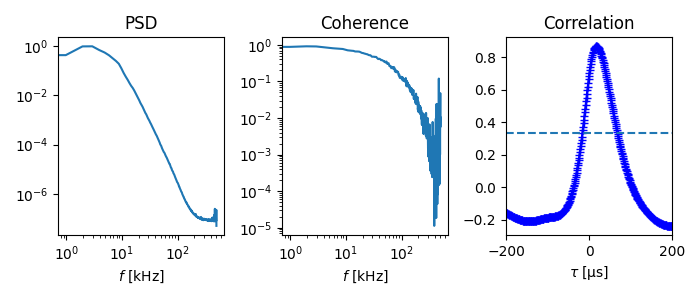

In [5]:
fig, axs = plt.subplots(1,3,figsize=(7,3))

[ax1,ax2,ax3] = axs
ax1.plot(f / 1e3, Pxx / Pxx.max())
ax2.plot(f / 1e3, coh)
ax3.plot(tau * 1e6, corr, 'b+-')

titles = ['PSD', 'Coherence', 'Correlation']
for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$f$ [kHz]')
    
ax3.set_xlim(-200, 200)
ax3.set_xlabel(r'$\tau$ [µs]')
ax3.axhline(coh.max() / np.exp(1), ls='--')

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
plt.tight_layout()

In [6]:
%autoreload 1
AutoCorr_Isat  = Corr_profile(Dat, 1, 1)
CrossCorr_phi  = Corr_profile(Dat, 0, 2)

In [7]:
CrossCorr_Isat_phi_up = Corr_profile(Dat, 0, 1) # probe 0 (phi 1) and probe 1 (I_sat)
CrossCorr_Isat_phi_down = Corr_profile(Dat, 2, 1) # probe 1 (I_sat) and probe 2 (phi_2)

(3, 13, 1048576)

[5. 5. 6. 6. 6. 6. 5. 5. 4. 4. 4. 3. 2.]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
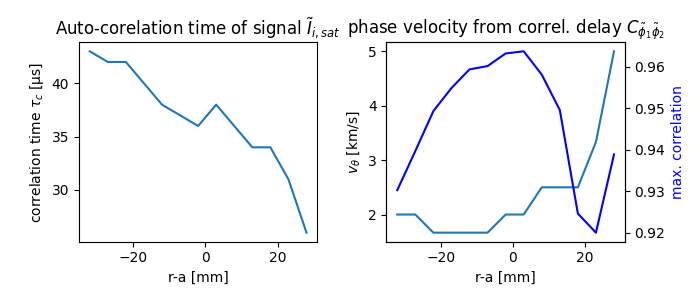

In [8]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

[ax1, ax2] = axs

tau_c = np.mean(np.abs( AutoCorr_Isat[:,:2] ), axis=1)
ax1.plot(R *1e3 ,  tau_c * 1e6)
ax1.set_xlabel('r-a [mm]')
ax1.set_ylabel(r'correlation time $\tau_c$ [µs]')
ax1.set_title(r'Auto-corelation time of signal $\tilde{I}_{i,sat}$')

tau_max = CrossCorr_phi[:,2]
max_corr = CrossCorr_phi[:,3]
vphase = 2 * dZ / tau_max
ax2.plot(R * 1e3, vphase * 1e-3)
ax2.set_title(r'phase velocity from correl. delay $C_{\tilde{\phi}_1 \tilde{\phi}_2}$')
ax2.set_ylabel(r'$v_\theta$ [km/s]')
ax2.set_xlabel('r-a [mm]')


_ax2 = ax2.twinx()
_ax2.plot(R *1e3, max_corr, color='blue')
_ax2.set_ylabel('max. correlation')
_ax2.yaxis.label.set_color('blue')

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
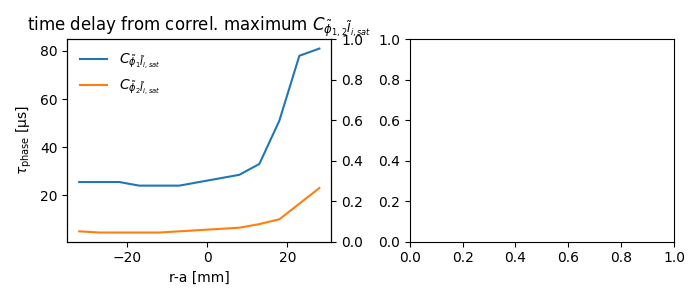

In [30]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

[ax1, ax2] = axs
_ax1 = ax1.twinx()

iphi = [1,2]

for i,C in enumerate([CrossCorr_Isat_phi_up, CrossCorr_Isat_phi_down]):
    tau_max = C[:,2]
    max_corr = C[:,3]

    vphase = 2 * dZ / tau_max
    vphase_correction =  (1-2*i) * dZ / vphase
    ax1.plot(R * 1e3, (tau_max - vphase_correction) * 1e6, label=r'$C_{\tilde{\phi}_{%d} \tilde{I}_{i,sat}}$' % iphi[i])
    #ax1.plot(R * 1e3, tau_max * 1e6, label=r'$C_{\tilde{\phi}_{%d} \tilde{I}_{i,sat}}$' % iphi[i])
    ax1.set_title(r'time delay from correl. maximum $C_{\tilde{\phi}_{1,2} \tilde{I}_{i,sat}}$')
    ax1.set_ylabel(r'$\tau_{\mathrm{phase}}$ [µs]')
    ax1.set_xlabel('r-a [mm]')
    
    #_ax1.plot(R * 1e3, max_corr, color='blue')


#_ax1.yaxis.label.set_color('blue')
ax1.legend(frameon=False)


plt.tight_layout()

Text(0.5, 0, 'r-a [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
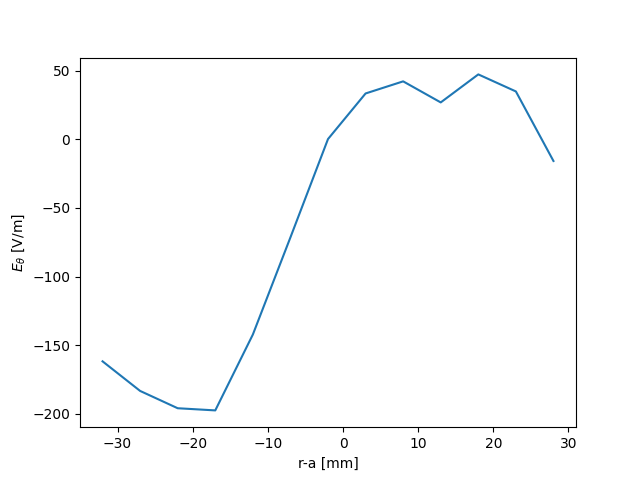

In [39]:
Efield = - np.mean(Dat[2] - Dat[0], axis=-1) / (2 * dZ)
B0 = 72e-3
vE = Efield/B0

fig ,ax = plt.subplots()
ax.plot(R * 1e3, Efield)
ax.set_ylabel(r'$E_\theta$ [V/m]')
ax.set_xlabel('r-a [mm]')

In [ ]:
Efield

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
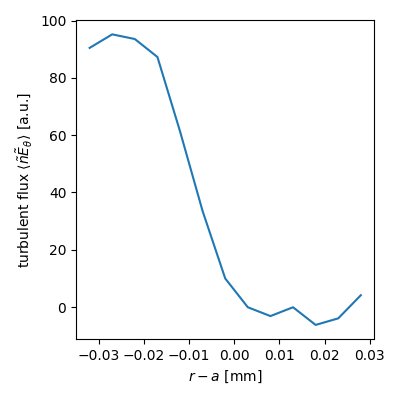

In [88]:
Efluct = - (Dat[2] - Dat[0]) / (2 * dZ) # in [V/m]
#Efluct = - (normalized(Dat[2]) - normalized(Dat[0])) / (2 * dZ) # in [V/m]
#Efluct = normalized(Efluct)
Isat = Dat[1]
#Isat = normalized(Dat[1])
Gamma = Isat * Efluct # flux in [a.u.]
Gamma_prof = np.mean(Gamma, axis=-1)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(R, -Gamma_prof)
ax.set_xlabel(r'$r -a$ [mm]')
ax.set_ylabel(r'turbulent flux $\langle \tilde{n} \tilde{E}_\theta \rangle$ [a.u.]')
plt.tight_layout()

From this, we infer the direction of the phase velocity, namely from bottom (probe 0) to top (probe 2). Moreover, we could get the phase in [rad] between density and potential fluctuations, knowing the (frequency 1-5 kHz) of the fluctuations.

Radial representation

In [15]:
for iR in range(R.size):
    f, Pxx = welch(Dat[1, iR], fs=1/dt, nperseg=nperseg)
    f, Pxy = csd(Dat[0, iR], Dat[1, iR], fs=1/dt, nperseg=nperseg)
    
    if iR==0:
        Spec = np.zeros((R.size, *Pxx.shape))
        CSpec = np.zeros((R.size, *Pxy.shape), dtype='complex')
    Spec[iR] = Pxx
    CSpec[iR] = Pxy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
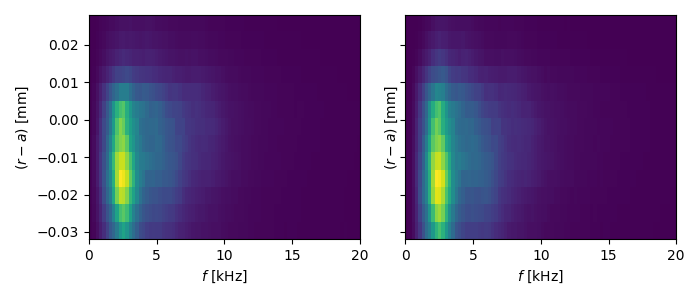

In [16]:
fig, axs = plt.subplots(1,2, figsize=(7,3), sharex=True, sharey=True)

plot_spec(Spec, f, ax=axs[0], cbar=False)
plot_spec(np.abs(CSpec), f, ax=axs[1], cbar=False)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
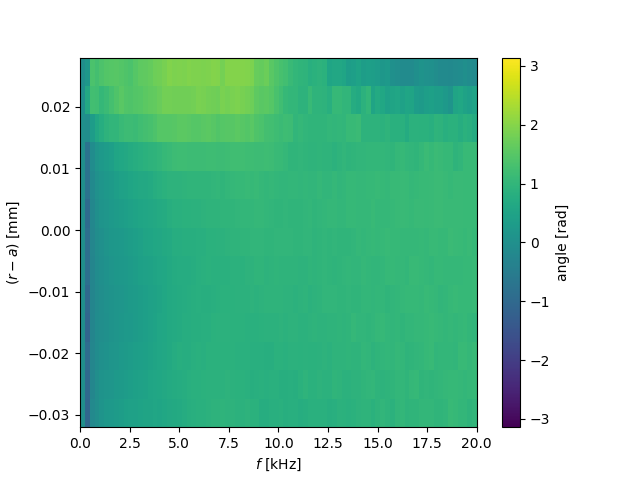

In [12]:
%autoreload 1
plot_spec(np.angle(CSpec), f, angle=True)

### Conditional averaging

In [49]:
sig = normalized(Dat[1, 7]) # saturation ion density signal at some radius
iblob = np.arange(sig.size)[sig > 2]
(sig > 2).sum() / sig.size

0.02667713165283203

In [50]:
iblob

array([    894,     895,     896, ..., 1048573, 1048574, 1048575])

Text(0.5, 0, '$t$ [ms]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
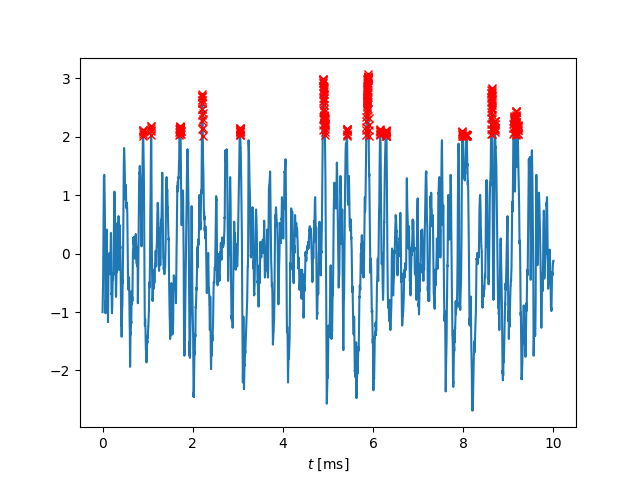

In [61]:
maxit = 10000
it = np.arange(maxit)
t = it * dt
fig, ax = plt.subplots()
ax.plot(t * 1e3, sig[it])

iblob_plot = iblob[iblob < maxit]
ax.plot(t[iblob_plot] * 1e3, sig[iblob_plot], 'rx')
ax.set_xlabel('$t$ [ms]')

In [60]:
iblob_left = np.diff(np.array(sig > 2, dtype=int))

1

In [ ]:
0.25 # ms , 250 pts avant/aprÈs

Isat PDF

In [52]:
bin_edges.shape, R.shape

((11,), (13,))

In [73]:
from utils import statistical_properties

In [80]:
for iR in range(R.size):
    _Isat = normalized(Dat[1, iR, :])
    
    
    
    hist, bin_edges = np.histogram(_Isat, bins=30, range=(-5,5))
    
    if iR == 0:
        Hist = np.zeros((R.size, *hist.shape))
        Kurtosis = np.zeros(R.size)
        Skew = np.zeros(R.size)
        
    
    binw = bin_edges[1] - bin_edges[0]
    
    # normalize
    hist = hist / (np.sum(hist) * binw) 
    
    Hist[iR] = hist
    
    bin_centers = bin_edges[1:] - binw/2
    
    # pdf propoerties
    _, Kurtosis[iR], Skew[iR], _ = statistical_properties(_Isat)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
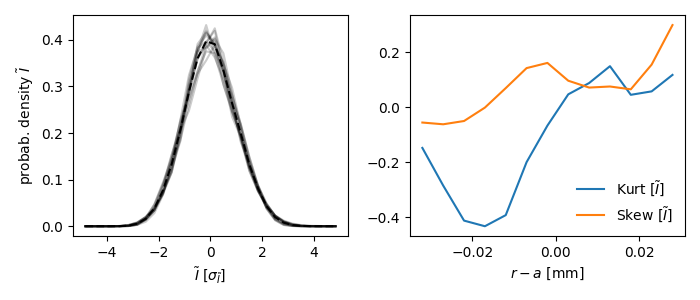

In [83]:
 
fig, [ax, ax2] = plt.subplots(1,2, figsize=(7,3))


#bin_center = np.hstack([ bin_edges, [bin_edges[-1] + binw]]) - binw / 2
for hist in Hist:
    ax.plot(bin_centers, hist, alpha=0.2, color='black')
    
ax.plot(bin_centers, np.mean(Hist, axis=0), ls='--', color='black')
ax.set_xlabel(r'$\tilde{I}$ [$\sigma_\tilde{I}$]')
ax.set_ylabel(r'probab. density $\tilde{I}$')

ax2.plot(R, Kurtosis, label=r'Kurt [$\tilde{I}$]')
ax2.plot(R, Skew, label=r'Skew [$\tilde{I}$]')
ax2.set_xlabel(r'$r -a$ [mm]')
ax2.legend(frameon=False)
plt.tight_layout()

In [ ]:
def annotation_text(probe, x, signal, nr_ms=None):
    # charact = charact_str[characteristic]

    text = ''
    if nr_ms is not None:
        text = 'measure No. {}\n'.format(nr_ms)

    if type(signal)==list:
        text_signal = 's: [{},{}]'.format(signal_dict[signal[0]], signal_dict[signal[1]])
    else:
        text_signal = ': ' + signal_dict[signal]
    text_signal = 'signal' +  text_signal

    if type(probe)==list:
        text_probe = 's: [{},{}]'.format(probe[0], probe[1])
    else:
        text_probe = ': {}'.format(probe)
    text_probe = 'probe' +  text_probe

    if x is None:
        text += '{}\n{}'.format(text_probe, text_signal)
    else:
        text += '{}\n$r = {}$ mm\n{}'.format(text_probe, x, text_signal)
    return text

def annotate_spectrum(ax, probe, x, characteristic, nr_ms=None, **kwargs):

    text = annotation_text(probe, x, characteristic, nr_ms)
    ax.text(0.97, 0.97, text, transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            **kwargs)

In [77]:
Skew, Kurtosis

(array([-0.05570951, -0.06207934, -0.05014096, -0.00126898,  0.06976581,
         0.1426619 ,  0.16152239,  0.09666382,  0.07172651,  0.07562301,
         0.0653673 ,  0.15544558,  0.29950881]),
 array([-0.14818176, -0.28550333, -0.4131355 , -0.43361001, -0.39313368,
        -0.20005685, -0.06681484,  0.04711248,  0.08819548,  0.14962233,
         0.04531229,  0.05785752,  0.11788679]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
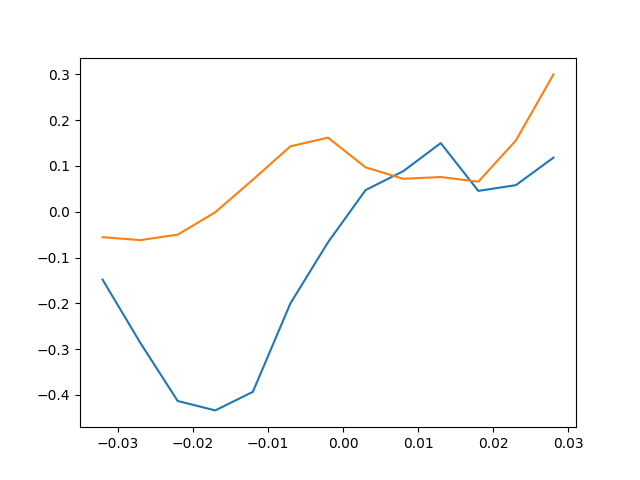

In [78]:
fig, ax = plt.subplots()
ax.plot(R, Kurtosis)
ax.plot(R, Skew)